In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [9]:


def train_flower_classifier(train_dir, test_dir, epochs=5):
    # Setup constants
    IMG_SIZE = (128, 128)
    BATCH_SIZE = 32
    
    # Create data generators
    data_generator = ImageDataGenerator(rescale=1.0/255)
    
    # Load and prepare data
    train_data = data_generator.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    
    test_data = data_generator.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    
    # Load MobileNetV2 with pre-trained ImageNet weights
    base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze base model
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(train_data.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile and train
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=test_data
    )
    
    # Evaluate
    loss, accuracy = model.evaluate(test_data)
    print(f"\nTest accuracy: {accuracy:.2f}")
    
    return model, train_data.class_indices

def detect_flowers(image_path, model, class_labels, confidence_threshold=0.95):
    # Load and prepare image
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    
    # Scanning parameters
    box_size = 128
    step_size = 64
    
    # Scan image
    for y in range(0, img.size[1] - box_size + 1, step_size):
        for x in range(0, img.size[0] - box_size + 1, step_size):
            # Get and process region
            region = img.crop((x, y, x + box_size, y + box_size))
            region = np.array(region.resize((128, 128))) / 255.0
            prediction = model.predict(np.expand_dims(region, 0), verbose=0)
            
            # Check confidence and draw if above threshold
            confidence = np.max(prediction)
            if confidence > confidence_threshold:
                flower_type = class_labels[np.argmax(prediction)]
                # Draw box and label
                draw.rectangle([(x, y), (x + box_size, y + box_size)], 
                             outline="green", width=2)
                draw.text((x, y - 10), 
                         f"{flower_type} ({confidence:.2f})", 
                         fill="green")
    
    # Display result
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()



In [10]:

# Example usage:

# Paths to training and testing data
train_dir = r"D:\Work\python\dl_clg\datasets\Flowers\train"
test_dir = r"D:\Work\python\dl_clg\datasets\Flowers\test"
model, class_indices = train_flower_classifier(train_dir, test_dir)



Found 3250 images belonging to 5 classes.
Found 530 images belonging to 5 classes.
Epoch 1/5
102/102 [==============================] - 9s 65ms/step - loss: 0.8662 - accuracy: 0.6778 - val_loss: 0.5380 - val_accuracy: 0.8245
Epoch 2/5
102/102 [==============================] - 6s 55ms/step - loss: 0.4129 - accuracy: 0.8569 - val_loss: 0.4430 - val_accuracy: 0.8434
Epoch 3/5
102/102 [==============================] - 6s 56ms/step - loss: 0.3225 - accuracy: 0.8855 - val_loss: 0.3892 - val_accuracy: 0.8717
Epoch 4/5
102/102 [==============================] - 6s 55ms/step - loss: 0.2695 - accuracy: 0.9046 - val_loss: 0.3819 - val_accuracy: 0.8679
Epoch 5/5
17/17 [==============================] - 1s 45ms/step - loss: 0.3572 - accuracy: 0.8792

Test accuracy: 0.88


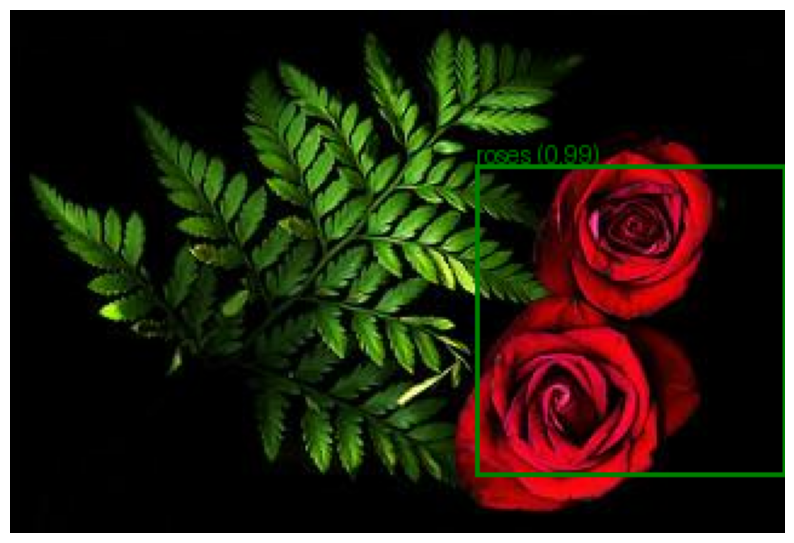

In [11]:

# Example usage:
image_path = r"D:\Work\python\dl_clg\datasets\Flowers\test\roses\roses_424.jpg"
class_labels = [ 'daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
detect_flowers(image_path, model, class_labels)